In [97]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def test_train_split(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

In [5]:
TRAIN_MONTH_OLD = '2015_05_28'
TRAIN_MONTH_NEW = '2015_06_28'

TEST_MONTH_OLD = '2016_05_28'
#TEST_MONTH_NEW = '2016_06_28'

TRAIN_FILE_OLD = 'data/train_' + TRAIN_MONTH_OLD + '.csv'
TRAIN_FILE_NEW = 'data/train_' + TRAIN_MONTH_NEW + '.csv'

ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH_OLD + '.csv'

TEST_FILE_OLD = 'data/train_' + TEST_MONTH_OLD + '.csv'
TEST_FILE_NEW = 'data/test_ver2.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

In [7]:
train_old = pd.read_csv(TRAIN_FILE_OLD, header=None, names=HEADER)
train_new = pd.read_csv(TRAIN_FILE_NEW, header=None, names=HEADER)
test_old = pd.read_csv(TEST_FILE_OLD, header=None, names=HEADER)
test_new = pd.read_csv(TEST_FILE_NEW)

added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
for col in HEADER[24:]:
    test_new[col] = [0]*test_new.shape[0]

In [25]:
combined = pd.concat((train_old, train_new, test_old, test_new)).reset_index(drop=True)

In [23]:
def process_data_from_original_dataframe(combined):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    combined['renta'] = pd.to_numeric(combined['renta'], errors='coerce')

    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']

    encoders = []
    for col in ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']:
        temp_enc = LabelEncoder()
        temp_enc.fit(combined[col])
        combined[col] = temp_enc.transform(combined[col])
        encoders.append(temp_enc)
    return combined, encoders



In [26]:
combined, encoders = process_data_from_original_dataframe(combined)

In [28]:
train_old = combined.loc[combined.fecha_dato == '2015-05-28', :].reset_index(drop=True)
train_new = combined.loc[combined.fecha_dato == '2015-06-28', :].reset_index(drop=True)
test_old = combined.loc[combined.fecha_dato == '2016-05-28', :].reset_index(drop=True)
test_new = combined.loc[combined.fecha_dato == '2016-06-28', :].reset_index(drop=True)

In [31]:
del train_old['index'], train_new['index'], test_old['index'], test_new['index']
del train_old['fecha_dato'], train_new['fecha_dato'], test_old['fecha_dato'], test_new['fecha_dato']

In [33]:
train_old.set_index('ncodpers', inplace=True)
train_new.set_index('ncodpers', inplace=True)
test_old.set_index('ncodpers', inplace=True)
test_new.set_index('ncodpers', inplace=True)

In [45]:
train_old['change_ind_empleado'] = train_old['ind_empleado'] == train_new.loc[train_old.index, 'ind_empleado']
test_old['change_ind_empleado'] = test_old['ind_empleado'] == test_new.loc[test_old.index, 'ind_empleado']

In [54]:
train_old['change_age'] = train_new.loc[train_old.index, 'age'] - train_old['age']
train_old.loc[train_old.change_age.isnull(), 'change_age'] = 0.0

test_old['change_age'] = test_new.loc[train_old.index, 'age'] - test_old['age']
test_old.loc[test_old.change_age.isnull(), 'change_age'] = 0.0


In [59]:
train_old['change_ind_nuevo'] = train_old['ind_nuevo'] == train_new.loc[train_old.index, 'ind_nuevo']
test_old['change_ind_nuevo'] = test_old['ind_nuevo'] == test_new.loc[test_old.index, 'ind_nuevo']

In [60]:
train_old['change_antiguedad'] = train_new.loc[train_old.index, 'antiguedad'] - train_old['antiguedad']
train_old.loc[train_old.change_antiguedad.isnull(), 'change_antiguedad'] = 0.0

test_old['change_antiguedad'] = test_new.loc[train_old.index, 'antiguedad'] - test_old['antiguedad']
test_old.loc[test_old.change_antiguedad.isnull(), 'change_antiguedad'] = 0.0


In [61]:
train_old['change_indrel'] = train_old['indrel'] == train_new.loc[train_old.index, 'indrel']
test_old['change_indrel'] = test_old['indrel'] == test_new.loc[test_old.index, 'indrel']

In [64]:
train_old['change_indrel_1mes'] = train_old['indrel_1mes'] == train_new.loc[train_old.index, 'indrel_1mes']
test_old['change_indrel_1mes'] = test_old['indrel_1mes'] == test_new.loc[test_old.index, 'indrel_1mes']

train_old['change_tiprel_1mes'] = train_old['tiprel_1mes'] == train_new.loc[train_old.index, 'tiprel_1mes']
test_old['change_tiprel_1mes'] = test_old['tiprel_1mes'] == test_new.loc[test_old.index, 'tiprel_1mes']

train_old['change_conyuemp'] = train_old['conyuemp'] == train_new.loc[train_old.index, 'conyuemp']
test_old['change_conyuemp'] = test_old['conyuemp'] == test_new.loc[test_old.index, 'conyuemp']

train_old['change_indfall'] = train_old['indfall'] == train_new.loc[train_old.index, 'indfall']
test_old['change_indfall'] = test_old['indfall'] == test_new.loc[test_old.index, 'indfall']

train_old['change_ind_actividad_cliente'] = train_old['ind_actividad_cliente'] == train_new.loc[train_old.index, 'ind_actividad_cliente']
test_old['change_ind_actividad_cliente'] = test_old['ind_actividad_cliente'] == test_new.loc[test_old.index, 'ind_actividad_cliente']

train_old['change_renta'] = train_new.loc[train_old.index, 'renta'] - train_old['renta']
train_old.loc[train_old.change_renta.isnull(), 'change_renta'] = 0.0

test_old['change_renta'] = test_new.loc[train_old.index, 'renta'] - test_old['renta']
test_old.loc[test_old.change_renta.isnull(), 'change_renta'] = 0.0

train_old['change_segmento'] = train_old['segmento'] == train_new.loc[train_old.index, 'segmento']
test_old['change_segmento'] = test_old['segmento'] == test_new.loc[test_old.index, 'segmento']

In [68]:
train_old['log_renta'] = np.log10(train_old['renta'])
test_old['log_renta'] = np.log10(test_old['renta'])

In [71]:
train_old.loc[424641, 'ind_ahor_fin_ult1':'ind_recibo_ult1']

ind_ahor_fin_ult1    0
ind_aval_fin_ult1    0
ind_cco_fin_ult1     1
ind_cder_fin_ult1    0
ind_cno_fin_ult1     0
ind_ctju_fin_ult1    0
ind_ctma_fin_ult1    0
ind_ctop_fin_ult1    1
ind_ctpp_fin_ult1    0
ind_deco_fin_ult1    0
ind_deme_fin_ult1    0
ind_dela_fin_ult1    0
ind_ecue_fin_ult1    0
ind_fond_fin_ult1    0
ind_hip_fin_ult1     0
ind_plan_fin_ult1    0
ind_pres_fin_ult1    0
ind_reca_fin_ult1    0
ind_tjcr_fin_ult1    0
ind_valo_fin_ult1    0
ind_viv_fin_ult1     0
ind_nomina_ult1      0
ind_nom_pens_ult1    0
ind_recibo_ult1      0
Name: 424641, dtype: object

In [72]:
product_history = pd.read_csv('data/product_history.csv')

In [74]:
product_history.set_index('ncodpers', inplace=True)

In [76]:
product_history.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
15889,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
15890,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,1,1
15891,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15892,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1
15893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
train_old['ind_recibo_ult1'] ^ product_history.loc[train_old.index, 'ind_recibo_ult1']

ncodpers
424641     0
465510     0
178087     0
465506     0
178089     0
465503     0
178094     0
1183071    0
178095     0
1183073    0
178085     0
481503     0
178105     0
178107     0
1183349    0
464836     0
141577     0
481502     0
178101     0
178045     0
465502     0
951229     0
178042     0
178020     0
178595     0
178586     0
178563     0
178565     0
609662     0
178567     0
          ..
1038074    0
1386604    1
1368705    0
1259548    0
509636     0
327721     0
1045337    0
1045339    0
1378293    0
1046101    0
1269083    0
785510     0
1049147    0
816139     0
738857     0
832092     1
327703     0
1046104    0
816127     0
1046123    0
1375637    0
784620     0
988130     0
826635     0
1045351    0
602177     0
1386600    0
287616     0
922980     0
371405     0
Name: ind_recibo_ult1, dtype: int64

In [78]:
for col in HEADER[24:]:
    train_old['change_from_history_' + col] = train_old[col] ^ product_history.loc[train_old.index, col]
    test_old['change_from_history_' + col] = test_old[col] ^ product_history.loc[test_old.index, col]

In [82]:
added_products.set_index('ncodpers', inplace=True)

label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])


In [84]:
x_main = train_old.loc[added_products.index, :]

xgb_main = xgb.DMatrix(x_main, label=added_products.encoded_products)

In [85]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

In [86]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 100
plist = param.items()

evallist = [(xgb_main, 'train')]

In [87]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval)

[0]	train-MAP@7:0.841634
[1]	train-MAP@7:0.843838
[2]	train-MAP@7:0.846832
[3]	train-MAP@7:0.845179
[4]	train-MAP@7:0.84585
[5]	train-MAP@7:0.846616
[6]	train-MAP@7:0.848293
[7]	train-MAP@7:0.848221
[8]	train-MAP@7:0.847862
[9]	train-MAP@7:0.848461
[10]	train-MAP@7:0.848772
[11]	train-MAP@7:0.849227
[12]	train-MAP@7:0.849395
[13]	train-MAP@7:0.849659
[14]	train-MAP@7:0.849683
[15]	train-MAP@7:0.849874
[16]	train-MAP@7:0.850018
[17]	train-MAP@7:0.850186
[18]	train-MAP@7:0.850449
[19]	train-MAP@7:0.850425
[20]	train-MAP@7:0.850713
[21]	train-MAP@7:0.850808
[22]	train-MAP@7:0.850904
[23]	train-MAP@7:0.851072
[24]	train-MAP@7:0.851192
[25]	train-MAP@7:0.851431
[26]	train-MAP@7:0.851503
[27]	train-MAP@7:0.851671
[28]	train-MAP@7:0.851815
[29]	train-MAP@7:0.852054
[30]	train-MAP@7:0.852246
[31]	train-MAP@7:0.852437
[32]	train-MAP@7:0.852605
[33]	train-MAP@7:0.852821
[34]	train-MAP@7:0.852964
[35]	train-MAP@7:0.85306
[36]	train-MAP@7:0.853156
[37]	train-MAP@7:0.853252
[38]	train-MAP@7:0.85337

In [88]:
final_test = xgb.DMatrix(test_old)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test_old['xgb_preds'] = [' '.join(x) for x in top_t_products]
test_old['added_products'] = ['ind_recibo_ult1']*test_old.shape[0]
for i in tqdm(test_old.index):
    zipped = zip(HEADER[24:],
                 test_old.loc[i, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test_old.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test_old.set_value(i, 'added_products', prod_string)

100%|██████████| 931453/931453 [14:25<00:00, 1075.83it/s]


In [89]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test_old.loc[submission.index, 'added_products']

filename = 'data/submissions/6.xgb_trained_on_jun_2015_only_added_users_change_in_user_features_btwn_old_month_and_change_in_product_history.csv'
description = 'xgb model trained on june 2015 on added products and more features\
               that track changes in ind_empleado, age, ind_nuevo, antiguedad,\
               indrel, indrel_1mes, tiprel_1mes, conyuemp, indfall, ind_actividad_cliente,\
               renta, segmento, between the current month and older month\
               and log of rent, and change whether product is subscribed now and\
               in its entire history:\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True)

Compressing file
Compression done
Uploading submission data/submissions/6.xgb_trained_on_jun_2015_only_added_users_change_in_user_features_btwn_old_month_and_change_in_product_history.csv.zip
Upload done


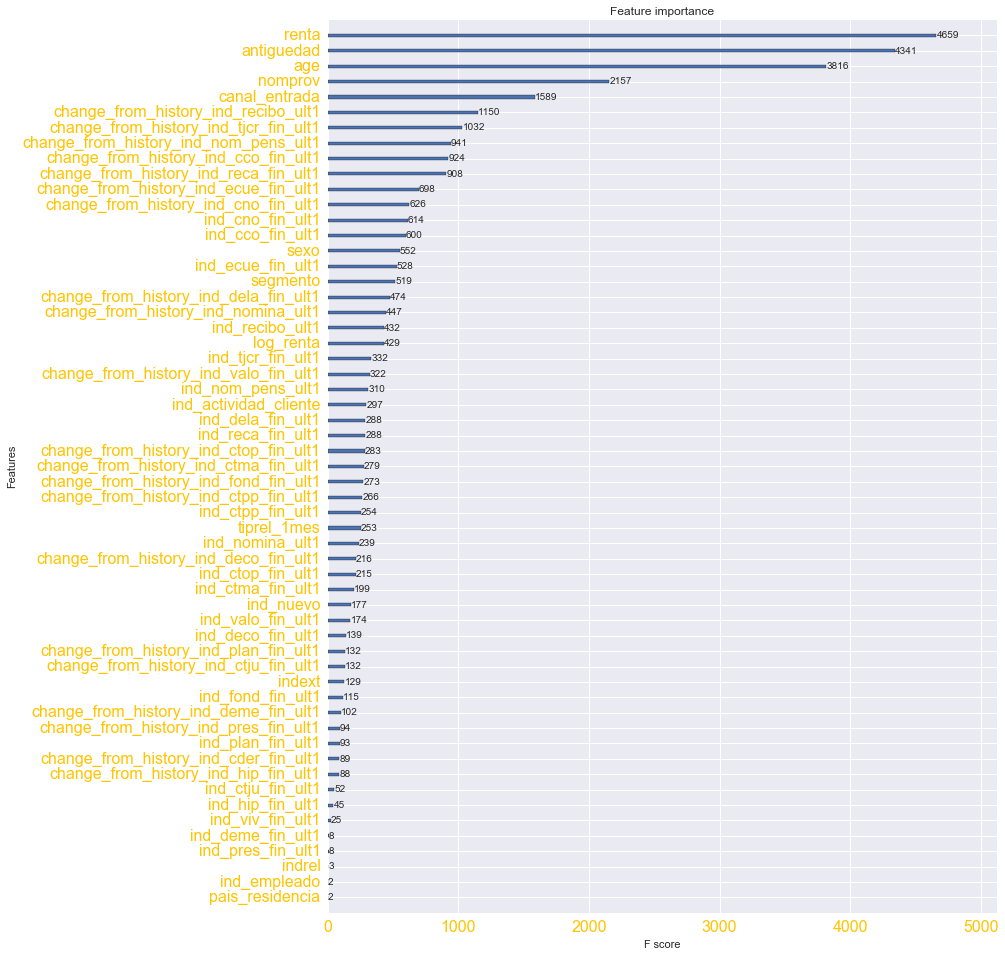

In [96]:
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=16, labelcolor="#ffc400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

In [104]:
set(test_old.columns) - set(xgb_model.get_fscore().keys())

{'added_products',
 'change_age',
 'change_antiguedad',
 'change_conyuemp',
 'change_from_history_ind_ahor_fin_ult1',
 'change_from_history_ind_aval_fin_ult1',
 'change_from_history_ind_viv_fin_ult1',
 'change_ind_actividad_cliente',
 'change_ind_empleado',
 'change_ind_nuevo',
 'change_indfall',
 'change_indrel',
 'change_indrel_1mes',
 'change_renta',
 'change_segmento',
 'change_tiprel_1mes',
 'conyuemp',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cder_fin_ult1',
 'indfall',
 'indrel_1mes',
 'indresi',
 'xgb_preds'}

In [106]:
len(final_test.feature_names)

79

In [107]:
orig_params = {'colsample_bytree': 0.6,
                'eta': 0.1,
                'gamma': 0.4,
                'max_delta_step': 7,
                'max_depth': 4,
                'min_child_weight': 1,
                'nthread': 4,
                'objective': 'multi:softprob',
                'scale_pos_weight': 0,
                'subsample': 0.75,
                'silent': 1
            }

tup = lambda t: list(itertools.izip(itertools.repeat(t[0]), t[1]))

def get_list_of_params(params_range):
    pr = list(map(tup, params_range.items()))
    pro = map(dict, list(itertools.product(*pr)))
    return pro


def grid_search_xgb(params_range_dict):
    grid_params_list = get_list_of_params(params_range_dict)
    p = Pool(2)
    maps = map(get_map_of_xgb, grid_params_list)
    p.close()
    p.join()
    sorted_maps = sorted(maps, cmp = lambda x, y: cmp(x['map'], y['map']), reverse = True)
    print "top map results", sorted_maps[:3]
    return sorted_maps

def get_map_of_xgb(grid_param):
    cv_params = dict(orig_params)
    num_class = {'num_class': len(label_encoder.classes_)}
    cv_params.update(num_class)
    cv_params.update(grid_param)
    # print orig_params, grid_param
    temp_cv = xgb.cv(cv_params, xgb_main, num_boost_round = 20, stratified=True,
             early_stopping_rounds = 20, feval = map7eval, maximize = True)
    temp_map = temp_cv['test-MAP@7-mean'][temp_cv.shape[0]-1]
    grid_param['map'] = temp_map
    # print "cv results", grid_param
    return grid_param

param_range1 = {
    'max_depth': range(2, 7, 2),
    'min_child_weight': range(1, 7, 2)
}
param_range2 = {
    'gamma': [i/10.0 for i in range(0, 6)],
    'colsample_bylevel': [i/10.0 for i in range(5, 10)]
}
param_range3 = {
    'max_delta_step': range(3, 10, 2)
}
param_range4 = {
    'subsample': [i/100.0 for i in range(80, 100, 5)],
    'colsample_bytree': [i/100.0 for i in range(80, 100, 5)]
}

21467

In [112]:
train_old.change_indrel.value_counts()

True     628603
False      3354
Name: change_indrel, dtype: int64